In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

from sklearn import preprocessing, decomposition, metrics
from sklearn.cluster import KMeans, DBSCAN

from sklearn.manifold import TSNE

#On importe des fonctions de visualitions pour notre ACP
from functions import *

# Mise en place des modèlisations

In [2]:
#On charge les données du dataframe optimisé
data_optimized = pd.read_csv("data_optimized.csv")
data_optimized_std = pd.read_csv("data_optimized_std.csv")

In [3]:
#On a ici décider de ne pas utiliser les catégories qualitatives
X = data_optimized_std[["amount","duration_last_order","number_orders"
                        ,"average_score","avg_payment_installments"]]

In [4]:
X

,amount,duration_last_order,number_orders,average_score,avg_payment_installments
0,0.385953,-0.505266,-0.387685,0.681953,1.702296
1,-1.636149,-0.476523,-0.387685,-0.065033,-0.896572
2,-0.277721,1.228116,-0.387685,-0.812019,1.702296
3,-1.301982,0.654467,-0.387685,-0.065033,0.836007
4,0.728136,0.533937,-0.387685,0.681953,1.342754
...,...,...,...,...,...
95414,3.000190,1.023293,1.655968,0.681953,1.981179
95415,-0.342144,0.428957,-0.387685,-0.065033,-0.896572
95416,-0.000158,1.292806,-0.387685,0.681953,-0.896572
95417,0.258148,-0.430192,-0.387685,0.681953,1.114890


## 1- DBSCAN

In [5]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [6]:
len(distances)

95419

Text(0.5, 1.0, '5-NN distance classé par ordre croissant')

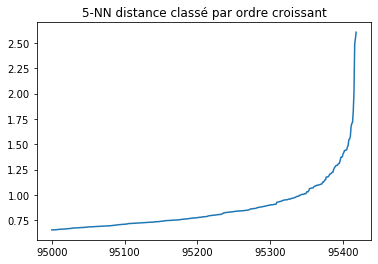

In [7]:
#On affiche ici la distance 5-NN de l'ensemble des points classés par ordre croissant
size = len(distances)
plt.plot(range(95000, size), distances[95000:]);
plt.title("5-NN distance classé par ordre croissant")

In [8]:
#On affiche la distance pour laquelle 99,9% des points ont une distance inférieur
distances[int(distances.size*0.999)]

0.952273342156839

In [9]:
#On lance notre modélisation DBSCAN
x_min = 0
x_max = size
y_pred = DBSCAN(eps = 0.95, min_samples=10).fit_predict(X[x_min:x_max])

In [10]:
#On obtient 4 clusters (-1 correspond aux valeurs abberantes)
y_pred = pd.Series(y_pred)
print(y_pred.value_counts())

 0    81011
 1    10453
 2     3666
-1      281
 3        8
dtype: int64


In [11]:
set(y_pred)

{-1, 0, 1, 2, 3}

In [12]:
#On ajoute la colonne cluster à notre dataframe
n = len(set(y_pred))
clusters = y_pred
data_optimized.loc[:,"cluster"] = clusters

In [13]:
#On créée ici un tableau de pourcentage permettant de mieux visualiser nos clusters
summarized_table = data_optimized.groupby(['cluster']).agg({
                    'customer_unique_id' : 'count',
                    'duration_last_order':'mean',
                    'number_orders':'mean',
                    'amount':'mean',
                    'average_score':'mean',
                    'avg_payment_installments':'mean'}).round(1)

summarized_table_p = summarized_table.copy()
summarized_table_p = summarized_table_p.iloc[:,1:]

summarized_table_p['duration_last_order'] = (summarized_table_p['duration_last_order']
                                           /(summarized_table_p['duration_last_order'].sum())*100).round(0)
summarized_table_p['number_orders'] = (summarized_table_p['number_orders']
                                    /(summarized_table_p['number_orders'].sum())*100).round(0)
summarized_table_p['amount'] = (summarized_table_p['amount']
                            /(summarized_table_p['amount'].sum())*100).round(0)
summarized_table_p['average_score'] = (summarized_table_p['average_score']
                            /(summarized_table_p['average_score'].sum())*100).round(0)
summarized_table_p['avg_payment_installments'] = (summarized_table_p['avg_payment_installments']
                            /(summarized_table_p['avg_payment_installments'].sum())*100).round(0)

summarized_table_p = summarized_table_p.T
summarized_table_p = summarized_table_p.iloc[:,1:]
summarized_table

,customer_unique_id,duration_last_order,number_orders,amount,average_score,avg_payment_installments
cluster,,,,,,
-1,281,145.8,7.6,1409.0,2.8,3.8
0,81011,242.9,1.0,131.2,4.1,2.9
1,10453,245.1,2.0,201.2,3.8,3.0
2,3666,251.0,3.9,312.9,3.7,3.2
3,8,29.8,3.0,399.3,1.1,9.8


In [14]:
#Pourcentage des clients par cluster
summarized_table["customer_unique_id"]/summarized_table["customer_unique_id"].sum()*100

cluster
-1     0.294491
 0    84.900282
 1    10.954841
 2     3.842002
 3     0.008384
Name: customer_unique_id, dtype: float64

In [15]:
summarized_table_p

cluster,0,1,2,3
duration_last_order,27.0,27.0,27.0,3.0
number_orders,6.0,11.0,22.0,17.0
amount,5.0,8.0,13.0,16.0
average_score,26.0,25.0,24.0,7.0
avg_payment_installments,13.0,13.0,14.0,43.0


Text(0.5, 1.0, 'Pourcentage de clients par variable (par cluster)')

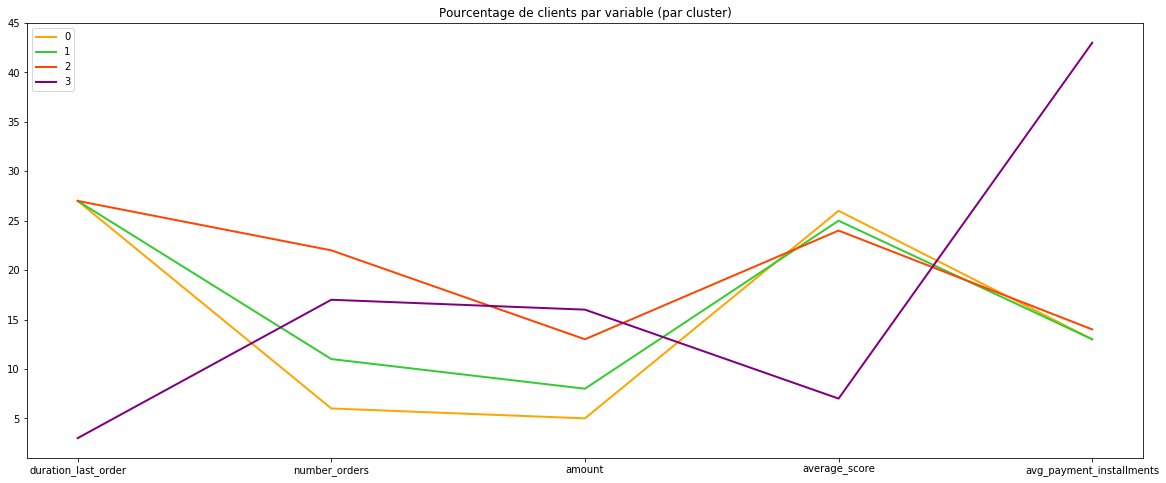

In [16]:
#On affiche ici l'importance de chaque variable pour chacun des clusters
label = summarized_table_p.columns.values
colors = ["orange","limegreen","orangered","purple"]

fig, ax = plt.subplots(figsize=(20,8))
for i in range(n-1):
    plt.plot(summarized_table_p.iloc[:,i], colors[i], linewidth=2)
plt.legend(label, loc = 'upper left')
plt.title("Pourcentage de clients par variable (par cluster)")

In [17]:
#On choisit de plutôt afficher nos clusters sur un graphique radar ce qui est plus pertinent
labels = np.array(summarized_table_p.index)
stats= summarized_table_p.loc[labels,].values

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
# close the plot
stats=np.concatenate((stats,[stats[0]]))
angles=np.concatenate((angles,[angles[0]]))

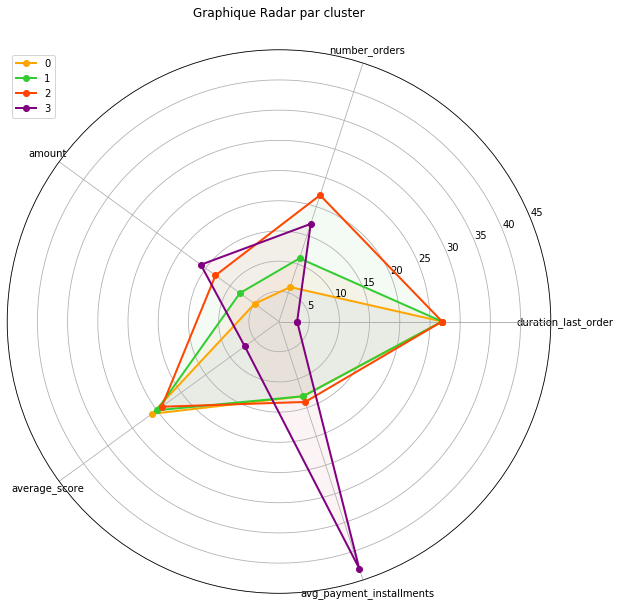

In [18]:
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
for i in range(n-1):
    ax.plot(angles, stats[:,i], 'o-', linewidth=2, c=colors[i])
    ax.fill(angles, stats[:,i], alpha=0.05)
    ax.set_thetagrids(angles * 180/np.pi, labels)
plt.legend(label, loc = 'upper left')
ax.set_title("Graphique Radar par cluster")
ax.grid(True)

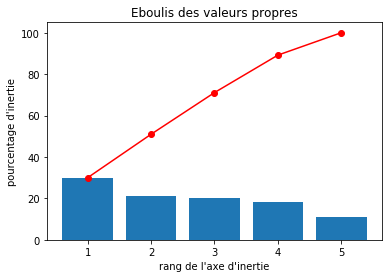

In [19]:
#Mise en place d'une ACP pour observer les résultats
n_comp = n
cluster = data_optimized["cluster"]
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X)
X_projected = pca.transform(X)

# Eboulis des valeurs propres
display_scree_plot(pca)

In [20]:
#On affiche le pourcentage de variance expliquée pour chacune de composantes principales
#Ici les 4 premières composantes expliquent 89% de la variance
np.cumsum(pca.explained_variance_ratio_*100)

array([ 29.99114158,  50.96600043,  71.0854992 ,  89.1814605 ,
       100.        ])

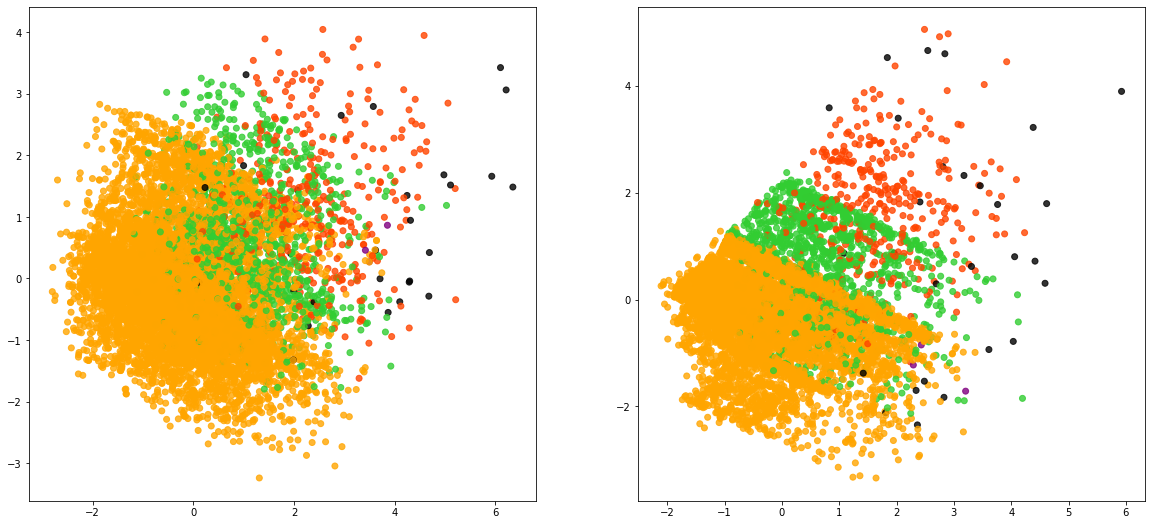

In [21]:
#On affiche 10000 individus sur les deux plans de notre ACP
color_cluster_DBSCAN = ["black" if i == -1 else colors[i] for i in y_pred]

x_min = 0
x_max = 10000

fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(221)
ax.scatter(X_projected[x_min:x_max,0], X_projected[x_min:x_max,1],c = color_cluster_DBSCAN[x_min:x_max], alpha=0.8)

ax = fig.add_subplot(222)
ax.scatter(X_projected[x_min:x_max,2], X_projected[x_min:x_max,3],c = color_cluster_DBSCAN[x_min:x_max], alpha=0.8)

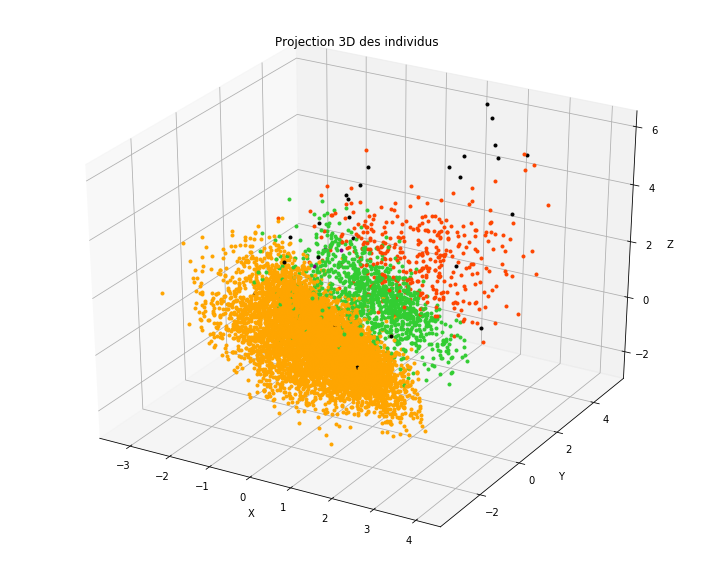

In [22]:
# Tracé du résultat en 3D
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')  # Affichage en 3D

ax = fig.gca(projection='3d')  # Affichage en 3D
for i in range(x_min,x_max):
    x = X_projected[i,1]
    y = X_projected[i,3]
    z = X_projected[i,0]

    ax.plot([x],[y],[z], ".", c = color_cluster_DBSCAN[i])  # Tracé de la courbe 3D

plt.title("Projection 3D des individus")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.show()

In [23]:
#Mise en place d'une tSNE pour tenter d'observer nos données
x_limit = 5000
tsne = TSNE(n_components=2, perplexity=100, verbose=1, random_state=123)
X_tsne = tsne.fit_transform(X[:x_limit])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.474s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.437683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.908012
[t-SNE] KL divergence after 1000 iterations: 0.759341


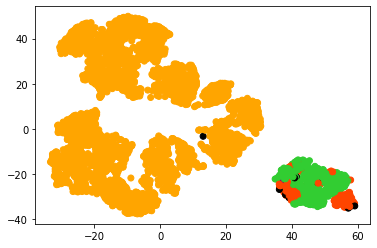

In [24]:
#La tSNE ne semble pas être le plus adapté pour observer nos données
plt.scatter(X_tsne[:,0],X_tsne[:,1], c=color_cluster_DBSCAN[:x_limit])

## 2- KMeans

In [25]:
inertia = []
silhouette = []
K_range = range(2,8)

#On cherche le nombre de clusters optimal
for k in K_range:
    model = KMeans(n_clusters=k).fit(X)
    inertia.append(model.inertia_)
    silhouette.append(metrics.silhouette_score(X, model.labels_))

Text(0.5, 1.0, 'Silhouette graph')

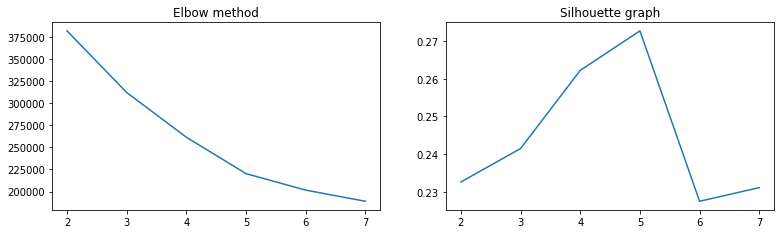

In [26]:
#On observe les graphes
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(5,3,1)
plt.plot(K_range, inertia)
plt.title("Elbow method")

ax2 = fig.add_subplot(5,3,2)
plt.plot(K_range, silhouette)
plt.title("Silhouette graph")

In [27]:
#On lance notre Kmeans avec un nombre de clusters égale à 5
n = 5
model = KMeans(n_clusters=n, random_state=30).fit(X)
model.labels_.shape

(95419,)

In [28]:
#On ajoute les clusters à notre dataframe
clusters = model.labels_
data_optimized.loc[:,"cluster"] = clusters

In [29]:
#On créée ici un tableau de pourcentage permettant de mieux visualiser nos clusters
summarized_table = data_optimized.groupby(['cluster']).agg({
                    'customer_unique_id' : 'count',
                    'duration_last_order':'mean',
                    'number_orders':'mean',
                    'amount':'mean',
                    'average_score':'mean',
                    'avg_payment_installments':'mean'}).round(1)

summarized_table_p = summarized_table.copy()
summarized_table_p = summarized_table_p.iloc[:,1:]

summarized_table_p['duration_last_order'] = (summarized_table_p['duration_last_order']
                                           /(summarized_table_p['duration_last_order'].sum())*100).round(0)
summarized_table_p['number_orders'] = (summarized_table_p['number_orders']
                                    /(summarized_table_p['number_orders'].sum())*100).round(0)
summarized_table_p['amount'] = (summarized_table_p['amount']
                            /(summarized_table_p['amount'].sum())*100).round(0)
summarized_table_p['average_score'] = (summarized_table_p['average_score']
                            /(summarized_table_p['average_score'].sum())*100).round(0)
summarized_table_p['avg_payment_installments'] = (summarized_table_p['avg_payment_installments']
                            /(summarized_table_p['avg_payment_installments'].sum())*100).round(0)

summarized_table_p = summarized_table_p.T
summarized_table

,customer_unique_id,duration_last_order,number_orders,amount,average_score,avg_payment_installments
cluster,,,,,,
0,13404,44.2,1.1,107.2,4.6,2.2
1,13285,252.2,1.1,144.6,1.4,3.0
2,21634,278.4,1.0,238.3,4.6,5.7
3,11520,255.2,2.7,281.6,4.1,3.2
4,35576,289.4,1.0,70.8,4.6,1.3


In [30]:
#Le pourcentage de clients par cluster
summarized_table["customer_unique_id"]/summarized_table["customer_unique_id"].sum()*100

cluster
0    14.047517
1    13.922804
2    22.672633
3    12.073067
4    37.283979
Name: customer_unique_id, dtype: float64

In [31]:
summarized_table_p

cluster,0,1,2,3,4
duration_last_order,4.0,23.0,25.0,23.0,26.0
number_orders,16.0,16.0,14.0,39.0,14.0
amount,13.0,17.0,28.0,33.0,8.0
average_score,24.0,7.0,24.0,21.0,24.0
avg_payment_installments,14.0,19.0,37.0,21.0,8.0


Text(0.5, 1.0, 'Pourcentage de clients par variable (par cluster)')

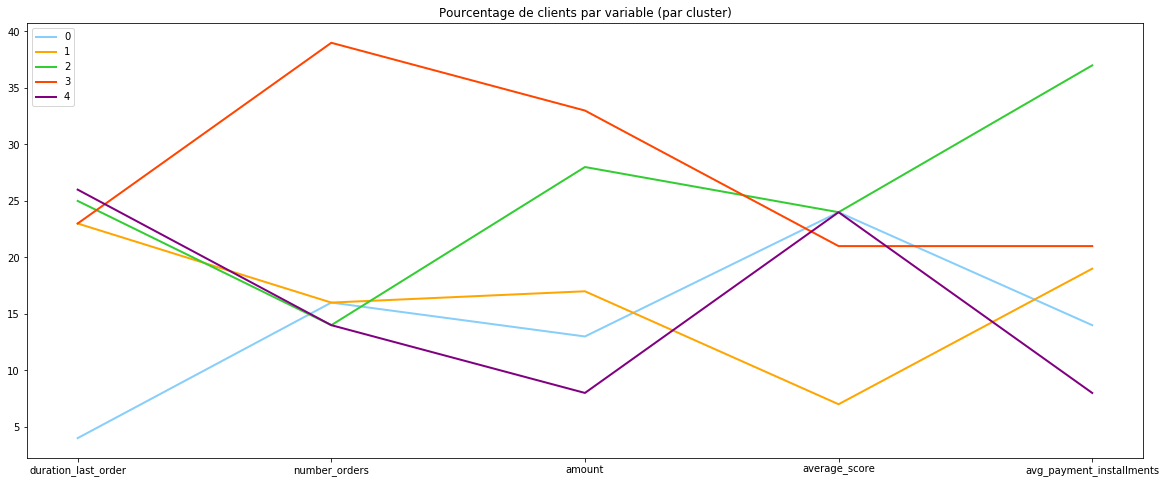

In [32]:
#On affiche ici l'importance de chaque variable pour chacun des clusters
label = summarized_table_p.columns.values
colors = ["lightskyblue","orange","limegreen","orangered","purple"]

fig, ax = plt.subplots(figsize=(20,8))
for i in range(n):
    plt.plot(summarized_table_p.iloc[:,i], colors[i], linewidth=2)
plt.legend(label, loc = 'upper left')
plt.title("Pourcentage de clients par variable (par cluster)")

In [33]:
#On décide d'afficher cela sous forme d'un graphique Radar ce qui est plus pertinent
labels = np.array(summarized_table_p.index)
stats= summarized_table_p.loc[labels,].values

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
stats=np.concatenate((stats,[stats[0]]))
angles=np.concatenate((angles,[angles[0]]))

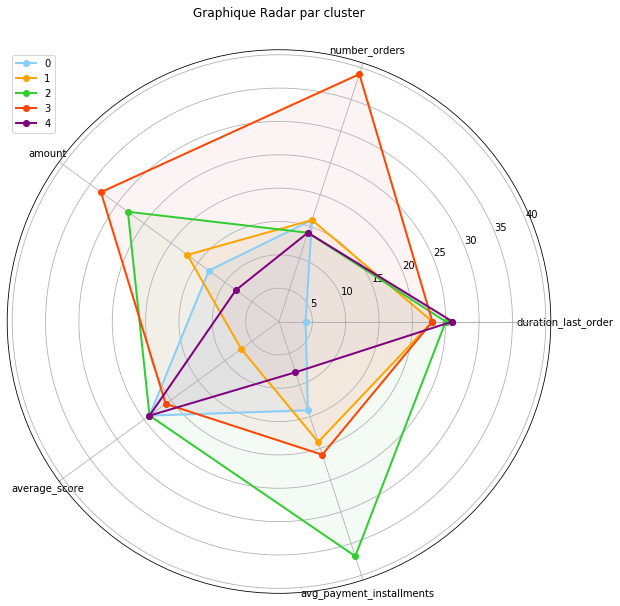

In [34]:
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
for i in range(n):
    ax.plot(angles, stats[:,i], 'o-', linewidth=2, c=colors[i])
    ax.fill(angles, stats[:,i], alpha=0.05)
    ax.set_thetagrids(angles * 180/np.pi, labels)
plt.legend(label, loc = 'upper left')
ax.set_title("Graphique Radar par cluster")
ax.grid(True)

In [35]:
#On change le type de la colonne cluster en Objet pour pourvoir l'exploiter comme une catégorie
data_optimized[['cluster']] = data_optimized[['cluster']].astype('O')
data_optimized["customer_state"].dtype

dtype('O')

In [36]:
data_exploration = data_optimized.copy()

#On enlève les valeurs aberrantes pour mieux visualiser les boxplot
Q1 = data_exploration[['amount']].quantile(0.25)[0]
Q3 = data_exploration[['amount']].quantile(0.75)[0]
IQR = Q3 - Q1
data_exploration = data_exploration[data_exploration['amount'] < Q3 + IQR * 1.5]

#On enlève les valeurs aberrantes pour mieux visualiser les boxplot
Q1 = data_exploration[['duration_last_order']].quantile(0.25)[0]
Q3 = data_exploration[['duration_last_order']].quantile(0.75)[0]
IQR = Q3 - Q1
data_exploration = data_exploration[data_exploration['duration_last_order'] < Q3 + IQR * 1.5]

Text(0.5, 1.0, 'Boxplot Nombre échéances par paiement')

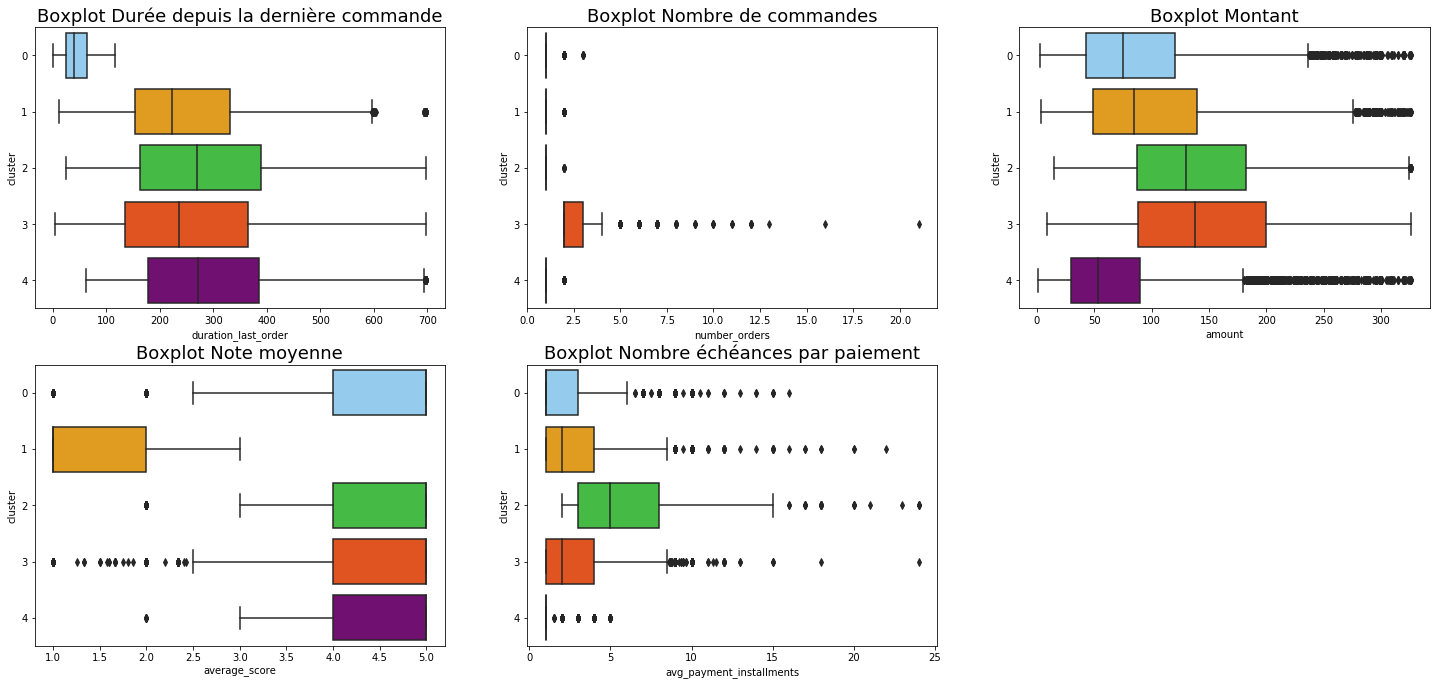

In [37]:
#On observe les boxplot par cluster pour chacune de nos variables quantitatives
fig = plt.figure(figsize=(25,30))
ax1 = fig.add_subplot(5,3,1)
sns.boxplot(x='duration_last_order',y = 'cluster', ax=ax1, data=data_exploration, orient="h"
            ,palette=colors)
plt.title("Boxplot Durée depuis la dernière commande", fontsize=18)

ax2 = fig.add_subplot(5,3,2)
sns.boxplot(x='number_orders',y = 'cluster', ax=ax2, data=data_exploration, orient="h"
            ,palette=colors)
plt.title("Boxplot Nombre de commandes", fontsize=18)

ax3 = fig.add_subplot(5,3,3)
sns.boxplot(x='amount',y = 'cluster', ax=ax3, data=data_exploration, orient="h"
            ,palette=colors)
plt.title("Boxplot Montant", fontsize=18)

ax3 = fig.add_subplot(5,3,4)
sns.boxplot(x='average_score',y = 'cluster', ax=ax3, data=data_exploration, orient="h"
            ,palette=colors)
plt.title("Boxplot Note moyenne", fontsize=18)

ax3 = fig.add_subplot(5,3,5)
sns.boxplot(x='avg_payment_installments',y = 'cluster', ax=ax3, data=data_exploration, orient="h"
            ,palette=colors)
plt.title("Boxplot Nombre échéances par paiement", fontsize=18)

<Figure size 720x720 with 0 Axes>

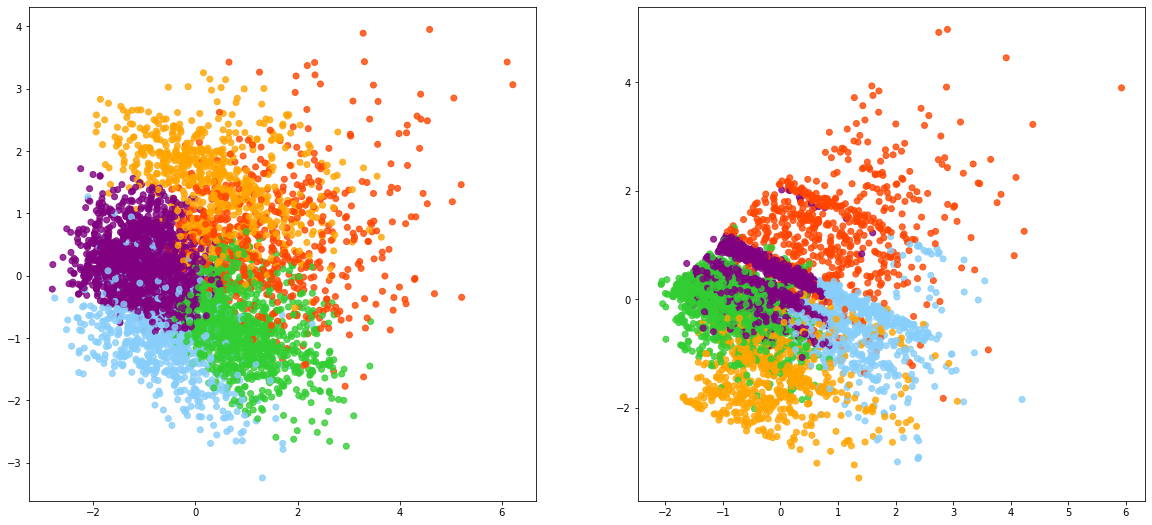

In [38]:
#Projection des individus sur les plans de notre ACP
min_ind = 0
max_ind = 5000

color_cluster = [colors[i] for i in data_optimized['cluster'].values]
fig = plt.figure(figsize=[10,10])


fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(221)
ax.scatter(X_projected[min_ind:max_ind,0], X_projected[min_ind:max_ind,1],c = color_cluster[min_ind:max_ind], alpha=0.8)

ax = fig.add_subplot(222)
ax.scatter(X_projected[min_ind:max_ind,2], X_projected[min_ind:max_ind,3],c = color_cluster[min_ind:max_ind], alpha=0.8)

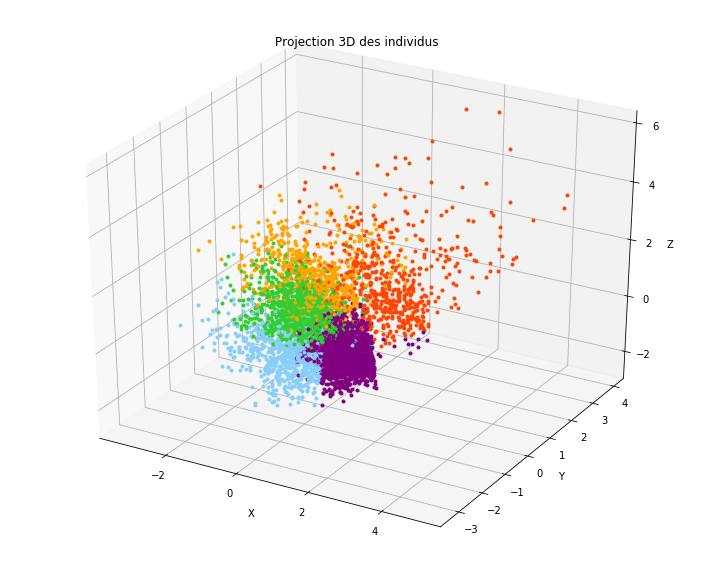

In [39]:
# Tracé du résultat en 3D
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')  # Affichage en 3D

ax = fig.gca(projection='3d')  # Affichage en 3D
for i in range(min_ind,max_ind):
    x = X_projected[i,3]
    y = X_projected[i,1]
    z = X_projected[i,0]

    ax.plot([x],[y],[z], ".", c = color_cluster[i])  # Tracé de la courbe 3D

plt.title("Projection 3D des individus")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.show()

In [40]:
#On entraine notre modèle avec un random_state différent pour tester la stabilité de notre modèle
model_test = KMeans(n_clusters=5, random_state=7).fit(X)
model_test.labels_.shape

(95419,)

In [41]:
#Calcule de l'ARI pour déterminer la stabilité 
metrics.adjusted_rand_score(model.labels_, model_test.labels_)

0.9989524663015429

In [42]:
#Calcule silhouette score de notre KMeans
metrics.silhouette_score(X, model.labels_)

0.27276871564089106

In [43]:
#On récupère ici les mois et les années de commandes de nos clients pour pouvoir tester la stabilité au cours du temps
data_stability = data_optimized.sort_values(by="last_order_purchase_timestamp")
data_stability.reset_index(level=0, inplace=True)
data_stability["last_order_purchase_year"] = pd.DatetimeIndex(data_stability["last_order_purchase_timestamp"].values).year
data_stability["last_order_purchase_month"] = pd.DatetimeIndex(data_stability["last_order_purchase_timestamp"].values).month
data_stability.head(5)

,index,Unnamed: 0,customer_unique_id,amount,number_orders,product_id,last_order_purchase_timestamp,duration_last_order,customer_state,review_comment_message,average_score,avg_payment_installments,product_category_name_english,cluster,last_order_purchase_year,last_order_purchase_month
0,68610,68610,b7d76e111c89f7ebf14761390f0f7d17,72.89,2,f293394c72c9b5fafd7023301fc21fc2,2016-09-04 21:15:19,728,RR,1 mes de atraso na entrega !!! ultima compra q...,1.0,1.0,furniture_decor,1,2016,9
1,27050,27050,4854e9b3feff728c13ee5fc7d1547e92,59.50,1,f3c2d01a84c947b078e32bbef0718962,2016-09-05 00:15:34,728,RS,Comprei dois produtos desta loja parceira da l...,1.0,3.0,telephony,1,2016,9
2,5480,5480,0eb1ee9dba87f5b36b4613a65074337c,100.00,1,d2998d7ced12f83f9b832f33cf6507b6,2016-10-02 22:07:52,700,SP,NaN,1.0,1.0,baby,1,2016,10
3,17750,17750,2f64e403852e6893ae37485d5fcacdaf,21.90,1,fd7fd78fd3cbc1b0a6370a7909c0a629,2016-10-03 16:56:50,700,RS,Tudo certo...,4.0,1.0,sports_leisure,4,2016,10
4,68958,68958,b8b8726af116a5cfb35b0315ecef9172,21.50,1,9c7bdf67b06b419aefb93cfdfc96c55d,2016-10-03 21:01:41,699,RJ,"O produto foi comprado em 10/10/2016, não cheg...",1.0,1.0,sports_leisure,1,2016,10


In [44]:
#Affiche du nombre de nouveaux clients par mois et par année
data_stability.groupby(['last_order_purchase_year','last_order_purchase_month']).agg({'customer_unique_id' : 'count'})

customer_unique_id
last_order_purchase_year last_order_purchase_month                    
2016                     9                                           2
                         10                                        296
2017                     1                                         724
                         2                                        1660
                         3                                        2509
                         4                                        2277
                         5                                        3455
                         6                                        3035
                         7                                        3770
                         8                                        4069
                         9                                        4033
                         10                                       4380
                         11                                       7186
                         12                                       5458
2018                     1                                        6983
                         2                                        6419
                         3                                        6998
                         4                                        6780
                         5                                        6724
                         6                                        6076
                         7                                        6174
                         8                                        6410
                         9                                           1

In [45]:
#On recupère les clients de 2016 et 2017
X_ref = data_stability[data_stability["last_order_purchase_year"].isin(["2016","2017"])][["amount","duration_last_order"
                                                                                  ,"number_orders","average_score"
                                                                                  ,"avg_payment_installments"]]

In [46]:
#On calcule l'ARI sur 2016 et 2017
n = 5
model_ref = KMeans(n_clusters=n, random_state=30).fit(X_ref)
model_ref.labels_.shape
clusters_ref = model_ref.labels_
ARI_ref = metrics.adjusted_rand_score(clusters_ref, clusters_ref)

In [47]:
#On calcule l'évolution de l'ARI au cours du temps
ARI_stability = []
ARI_stability.append(ARI_ref)
print("Ref : ",metrics.adjusted_rand_score(clusters_ref, clusters_ref))
for i in range(1,12):
    X_test = data_stability[(data_stability["last_order_purchase_year"].isin(["2016","2017"]))
                   |((data_stability["last_order_purchase_year"].isin(["2018"]))
                   &((data_stability["last_order_purchase_month"] <= i)))][["amount","duration_last_order"
                                                                                      ,"number_orders","average_score"
                                                                                      ,"avg_payment_installments"]]
    model_test = KMeans(n_clusters=n, random_state=30).fit(X_test)
    clusters_test = model_test.labels_
    clusters_test = clusters_test[:len(clusters_ref)]
    ARI_test = metrics.adjusted_rand_score(clusters_ref, clusters_test)
    ARI_stability.append(ARI_test)
    print("Ref+",i,"mois :", round(ARI_test,1))
#     print(len(clusters_ref),len(clusters_test))

Ref :  1.0
Ref+ 1 mois : 0.8
Ref+ 2 mois : 0.7
Ref+ 3 mois : 0.5
Ref+ 4 mois : 0.4
Ref+ 5 mois : 0.4
Ref+ 6 mois : 0.3
Ref+ 7 mois : 0.2
Ref+ 8 mois : 0.2
Ref+ 9 mois : 0.2
Ref+ 10 mois : 0.2
Ref+ 11 mois : 0.2


<BarContainer object of 12 artists>

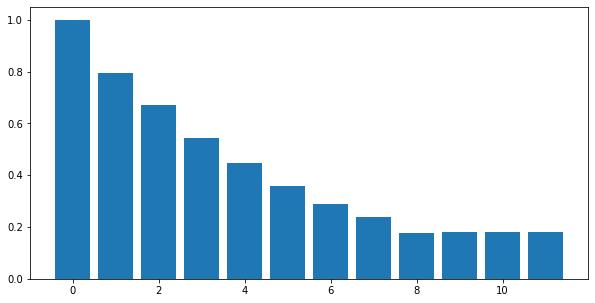

In [48]:
#On affiche l'ARI au fur et à mesure des mois
plt.figure(figsize=(10, 5))
plt.bar(range(len(ARI_stability)), ARI_stability)

# Analyse comportementale des clusters

In [49]:
#on crée un dataframe par cluster pour pouvoir analyser le comportements de nos clients
data_exploration_clusters = []
for i in range(5):
    data_exploration_clusters.append(data_exploration[data_exploration['cluster'] == i])
    
palette_colors = ["Blues_r","Oranges_r","Greens_r","Reds_r","Purples_r"]

AxesSubplot(0.766379,0.749828;0.133621x0.130172)


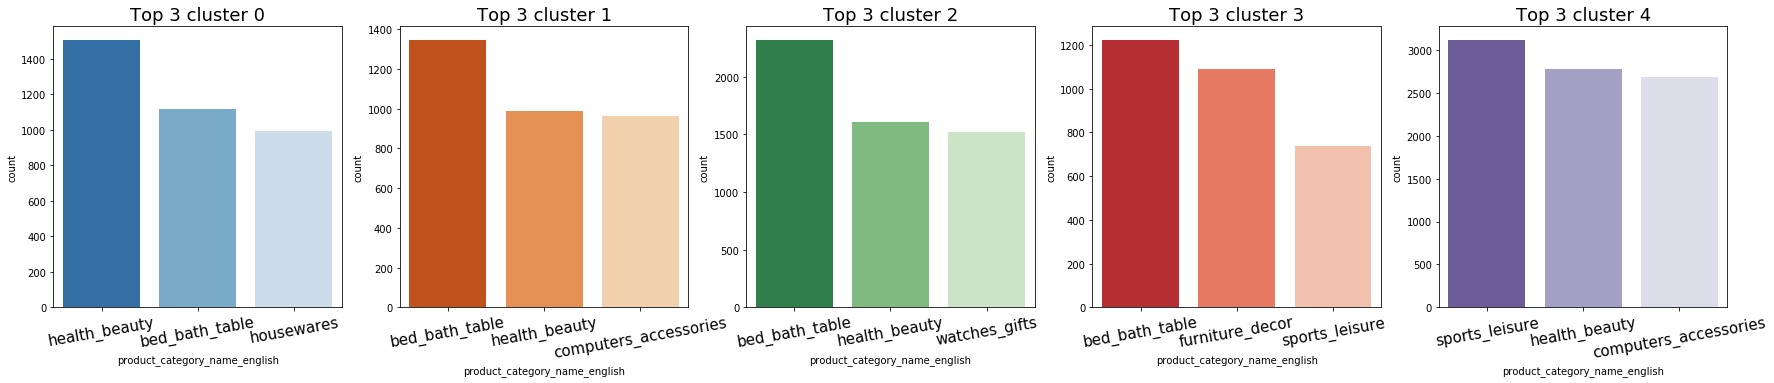

In [50]:
#On observe les catégories par cluster
fig = plt.figure(figsize=(30,30))

for i in range(5):
    ax = fig.add_subplot(5,5,i+1)
    graph = sns.countplot(x='product_category_name_english', ax=ax, 
                          data=data_exploration_clusters[i]
                         ,palette=palette_colors[i], order=data_exploration_clusters[i]['product_category_name_english']
                          .value_counts().index[:3])
    graph.set_title('Top 3 cluster '+str(i), fontsize=18)
    graph.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=10)
print(graph)

AxesSubplot(0.766379,0.749828;0.133621x0.130172)


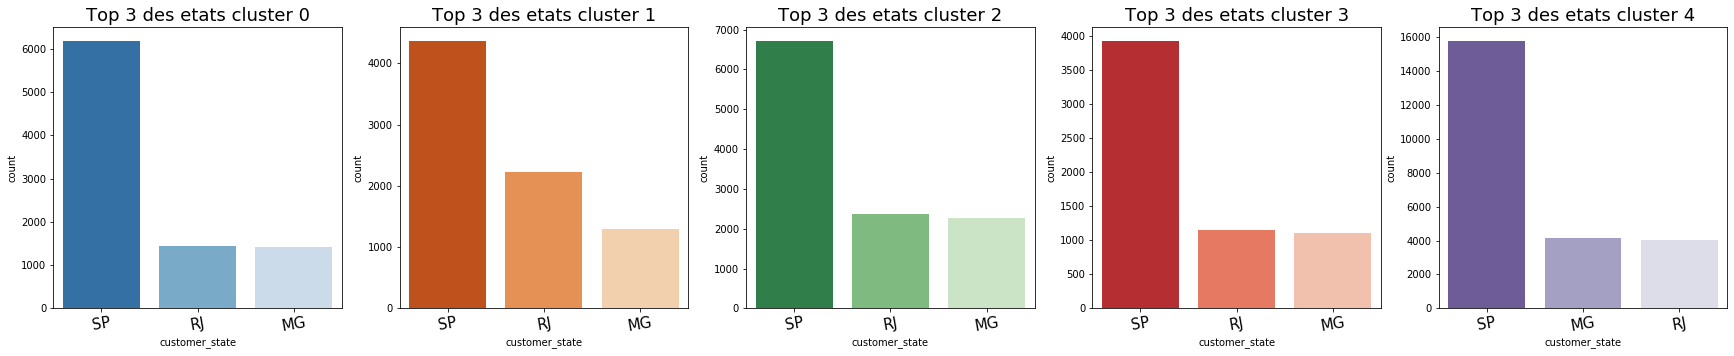

In [51]:
#On observe les états par cluster
fig = plt.figure(figsize=(30,30))

for i in range(5):
    ax = fig.add_subplot(5,5,i+1)
    graph = sns.countplot(x='customer_state', ax=ax, 
                          data=data_exploration_clusters[i]
                         ,palette=palette_colors[i], order=data_exploration_clusters[i]['customer_state']
                          .value_counts().index[:3])
    graph.set_title('Top 3 des etats cluster '+str(i), fontsize=18)
    graph.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=10)
print(graph)

In [52]:
#On observe le type de commentaires par cluster
for i in range(5):
    liste_comment = list(data_exploration_clusters[i][data_exploration_clusters[i]["review_comment_message"]
                                                      .notnull()]["review_comment_message"])
    print("Liste commentaires cluster ",i)
    print(liste_comment[:5])
    print("--------------------------------------------------------------------------------------------------")

Liste commentaires cluster  0
['Super recomendo. Entregaram antes do prazo otimo', 'Recebi o produto. É de ótima qualidade. Só o cadeado que acompanha o produto que veio com defeito. ', 'Não recebi a capa De sofá. Estou aguardando e não estou informada de quando virá', 'Muito bom', 'Faltou orientações mais detalhadas sobre a instalação']
--------------------------------------------------------------------------------------------------
Liste commentaires cluster  1
['Até o presente momento não recebi o produto e não entraram em contato comigo para dar alga satisfação e fazer o reembolso.', 'Ainda não abri a embalagem! ', 'Sendo um produto de cerâmica, é frágil. Ao desembalar, já apresentava sinal de batida e trincas. Pedi devolução e estou aguardando contato. Necessário, além do plástico bolha, espuma na embalagem.', 'Não um telefone onde podemos falar sobre o deu errado, e por email não obtive resposta', 'Bom dia\r\nNão recebi o produto e tambem não recebi nenhum aviso dos correios. Es